## Laboratorio 4 - Redes Neuronales
### Integrantes:
- Martín Beiro
- Julian Rodriguez

### 1. Carga de librerias

In [15]:
import torch 
import torchvision
import sklearn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

#elegimos el dispositivo a utilizar. Si hay gpyu lo usamos, sino la cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2. Carga de datos

El Dataset Fashion-MNIST es un conjunto de imagenes  de 10 tipos de artículos de vestimenta, con 70.000 imágenes de 28x28 en blanco y negro.
 Pytorch incluye facilidades para cargar este dataset desde su librería torchvision 

In [103]:


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.FashionMNIST(root="./data", train=True,  download=True,  transform=transform, target_transform=None )

test_data = datasets.FashionMNIST(root="./data",train=False, download=True,  transform=transform)
clases=train_data.classes
print(clases)



['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Las clases presentes en el set de datos son: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'

Observemos una de las muestras del conjunto de entrenamiento y su categoría

Text(0.5, 1.0, 'Ankle boot')

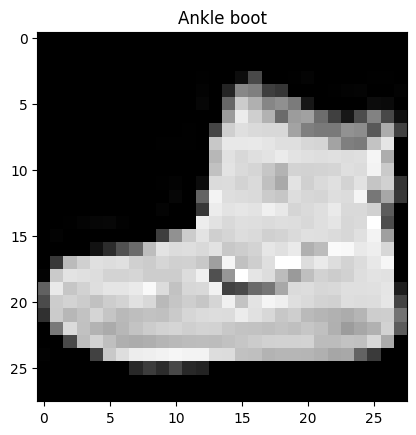

In [104]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(clases[label])

Para entrenar nos conviene crear Dataloaders, que manejan la división de los conjuntos en minibatches. Comenzaremos con un batch size típico de 32 muestras. Al modificar la cantidad de muestras en nuestro batch, modificamos la memoria que se utiliza en cada iteración, cuantas cuentas se hacen en cada epoch, y también reducimos la estocasticidad al tomar un subconjunto de muestras más grande. 


In [105]:
BATCH_SIZE = 64


train_dataloader =torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,  shuffle=True )

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False )


### 3. Red Feedforward Base

Como base, construiremos una red Feedforward sencilla, de una capa oculta, 32 unidades y activación Sigmoide. En las Siguientes secciones haremos esfuerzos por mejorar los resultados de la red base modificando hiperparámetros como cantidad de capas ocultas, funciones de activación y cantidad de unides ocultas.

Primero se crea la clase de la red como subclase de Pytorch Module, clase base para los modelos en este framework. Se debe incorporar una capa Flatten para pasar las imágenes a vectores unidimensionales , por lo que cada batch de entrada nos queda con la forma (1,28x28,tamaño del batch)

In [106]:
class FFv0(torch.nn.Module):
    def __init__(self,input_shape,hidden_dimention):
        super().__init__()
        self.capas= torch.nn.Sequential(  
        torch.nn.Flatten(),
        torch.nn.Linear(input_shape, hidden_dimention),
        torch.nn.Sigmoid(),
        torch.nn.Linear(hidden_dimention, 10),
        torch.nn.Sigmoid())
    def forward(self, x):
        return self.capas(x)
    


Luego creamos el loop de entrenamiento y lo entrenamos durante 10 epocas, con un learning rate de 0.01. 

In [107]:

def train_step(model, train_dataloader, loss_fn, optimizer):
    model.train()
    train_loss= 0
    train_acc= 0
    for images, labels in train_dataloader:
        #forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        train_loss += loss
        #backprop
        optimizer.zero_grad()
        loss.backward()
        #actualizo el modelo
        optimizer.step()
        predictions=outputs.argmax(dim=1)

        train_acc += ((predictions==labels).sum().item()/len(labels))*100
    train_acc /= len(train_dataloader)
    train_loss /= len(train_dataloader)
    return train_loss, train_acc

def test_step(model, test_dataloader, loss_fn):
    model.eval()
    total=0
    correct=0
    test_loss=0
    test_acc=0
    with torch.inference_mode():
        for images, labels in test_dataloader:
            outputs = model(images)
            test_loss+=loss_fn(outputs, labels)
            predictions=outputs.argmax(dim=1)
            test_acc += ((predictions==labels).sum().item()/len(labels))*100
        # Adjust metrics and print out
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        return test_loss, test_acc

def train_model(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs,verbose=True):
    history = dict(train_loss=[], train_acc=[], test_loss=[], test_acc=[])
    for epoch in range(epochs):



        train_loss, train_acc = train_step(model_v0, train_dataloader, loss_fn, optimizer)
        test_loss, test_acc = test_step(model_v0, test_dataloader, loss_fn)
        if verbose:
            print(f"Epoca: {epoch+1} ---")

            print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%\n")
            print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
            print ("------------")
        history["train_loss"].append(train_loss.item())
        history["train_acc"].append(train_acc)

        history["test_acc"].append(test_acc)
        history["test_loss"].append(test_loss.item())
    return history


lr=0.01
epochs=10
torch.manual_seed(55)
model_v0=FFv0(28*28,32).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_v0.parameters(), lr=lr)

history=train_model(model_v0, train_dataloader, test_dataloader, loss_fn, optimizer, epochs)

Epoca: 1 ---
Train loss: 2.24155 | Train accuracy: 29.53%

Test loss: 2.18129 | Test accuracy: 42.52%

------------
Epoca: 2 ---
Train loss: 2.12893 | Train accuracy: 51.31%

Test loss: 2.08314 | Test accuracy: 57.68%

------------
Epoca: 3 ---
Train loss: 2.04682 | Train accuracy: 60.94%

Test loss: 2.01677 | Test accuracy: 63.11%

------------
Epoca: 4 ---
Train loss: 1.99155 | Train accuracy: 64.04%

Test loss: 1.97114 | Test accuracy: 64.43%

------------
Epoca: 5 ---
Train loss: 1.95210 | Train accuracy: 64.69%

Test loss: 1.93713 | Test accuracy: 64.22%

------------
Epoca: 6 ---
Train loss: 1.92164 | Train accuracy: 64.63%

Test loss: 1.91004 | Test accuracy: 63.69%

------------
Epoca: 7 ---
Train loss: 1.89679 | Train accuracy: 64.00%

Test loss: 1.88760 | Test accuracy: 63.03%

------------
Epoca: 8 ---
Train loss: 1.87589 | Train accuracy: 63.07%

Test loss: 1.86852 | Test accuracy: 61.70%

------------
Epoca: 9 ---
Train loss: 1.85790 | Train accuracy: 62.21%

Test loss: 1.

Observemos la evolución del Accuracy y la pérdida, para poder interpretar mejor los resultados

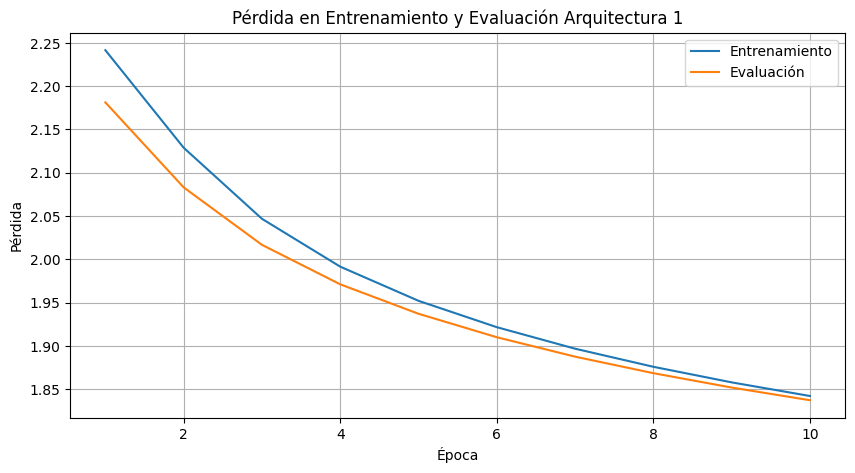

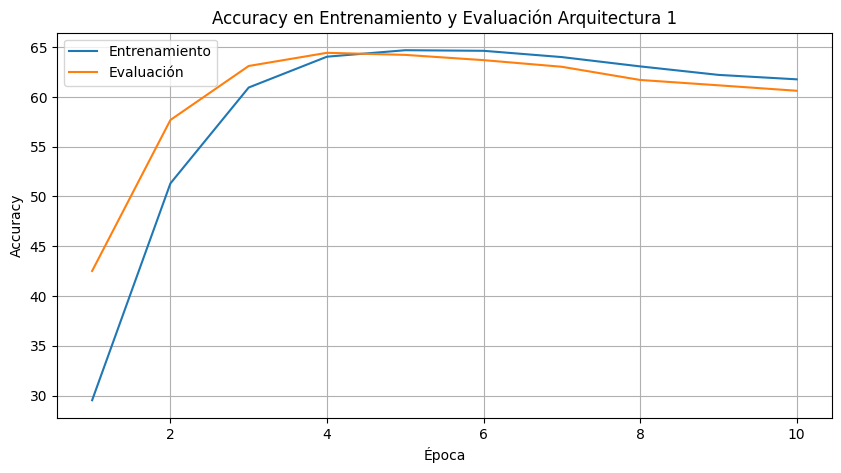

In [108]:
train_losses = history["train_loss"]
eval_losses = history["test_loss"]
train_accs = history["train_acc"]
eval_accs = history["test_acc"]


plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Entrenamiento")
plt.plot(range(1, len(eval_losses) + 1), eval_losses, label="Evaluación")
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida en Entrenamiento y Evaluación Arquitectura 1')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label="Entrenamiento")
plt.plot(range(1, len(eval_accs) + 1), eval_accs, label="Evaluación")
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy en Entrenamiento y Evaluación Arquitectura 1')
plt.grid(True)
plt.show()


La curva de las pérdidas parece correcta, aunque tal vez un poco lenta, de todas maneras habria que entrenar  por más épocas para poder sacar conclusiones. No se ve overfitting, al menos observando esta gráfica, porque van juntas las pérdidas de entrenamiento y evaluación. 
Por otro lado, el comportamiento del Accuracy de entrenamiento y de Evaluación es peculiar, porque disminuye aunque la pérdida esté subiendo. Esto podría explicarse porque el Accuracy y la pérdida están midiendo aspectos diferentes del modelo, ya que uno solo toma en cuenta si se acertó a la categoría, y el otro mira que tan cerca estuvo esa probabilidad de 1, y que tan lejos estuvieron las demás de cero. 

### 4. Mejoras a la arquitectura

Con el fin de mejorar los resultados, podemos realizar pruebas modificando algunas características de la red y de su entrenamiento.  Lo primero, sería ver si la capacidad de la red es suficiente para hacer un overfitting de los datos, y ver como se comporta ante distintos learning rates

In [101]:

lr=0.5
epochs=100
torch.manual_seed(55)
model_v0=FFv0(28*28,32).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_v0.parameters(), lr=lr)

history=train_model(model_v0, train_dataloader, test_dataloader, loss_fn, optimizer, epochs)

Epoca: 1 ---
Train loss: 1.84184 | Train accuracy: 44.51%

Test loss: 1.72165 | Test accuracy: 44.79%

------------
Epoca: 2 ---
Train loss: 1.69445 | Train accuracy: 46.96%

Test loss: 1.68247 | Test accuracy: 46.28%

------------
Epoca: 3 ---
Train loss: 1.67034 | Train accuracy: 47.54%

Test loss: 1.66740 | Test accuracy: 46.65%

------------
Epoca: 4 ---
Train loss: 1.65859 | Train accuracy: 47.82%

Test loss: 1.65848 | Test accuracy: 47.64%

------------
Epoca: 5 ---
Train loss: 1.65097 | Train accuracy: 48.25%

Test loss: 1.65256 | Test accuracy: 47.95%

------------
Epoca: 6 ---
Train loss: 1.64492 | Train accuracy: 48.71%

Test loss: 1.64774 | Test accuracy: 48.16%

------------
Epoca: 7 ---
Train loss: 1.64012 | Train accuracy: 49.97%

Test loss: 1.64420 | Test accuracy: 48.02%

------------
Epoca: 8 ---
Train loss: 1.63635 | Train accuracy: 51.75%

Test loss: 1.64080 | Test accuracy: 49.83%

------------
Epoca: 9 ---
Train loss: 1.63264 | Train accuracy: 52.62%

Test loss: 1.

In [102]:
lr=5
epochs=10
torch.manual_seed(55)
model_v1=FFv0(28*28,32).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_v0.parameters(), lr=lr)

history=train_model(model_v0, train_dataloader, test_dataloader, loss_fn, optimizer, epochs)

Epoca: 1 ---
Train loss: 1.58197 | Train accuracy: 71.51%

Test loss: 1.59862 | Test accuracy: 68.51%

------------
Epoca: 2 ---
Train loss: 1.57636 | Train accuracy: 73.00%

Test loss: 1.59824 | Test accuracy: 72.52%

------------
Epoca: 3 ---
Train loss: 1.57493 | Train accuracy: 72.44%

Test loss: 1.59318 | Test accuracy: 71.27%

------------
Epoca: 4 ---
Train loss: 1.57382 | Train accuracy: 73.68%

Test loss: 1.58704 | Test accuracy: 71.94%

------------
Epoca: 5 ---
Train loss: 1.57242 | Train accuracy: 74.17%

Test loss: 1.63528 | Test accuracy: 65.08%

------------
Epoca: 6 ---
Train loss: 1.57110 | Train accuracy: 75.10%

Test loss: 1.59295 | Test accuracy: 69.25%

------------
Epoca: 7 ---
Train loss: 1.56982 | Train accuracy: 75.14%

Test loss: 1.58953 | Test accuracy: 73.48%

------------
Epoca: 8 ---
Train loss: 1.56873 | Train accuracy: 76.19%

Test loss: 1.59064 | Test accuracy: 76.68%

------------
Epoca: 9 ---
Train loss: 1.56767 | Train accuracy: 76.71%

Test loss: 1.

Tomando el resultado obtenido en la época , podemos proceder a intentar superarlo. Proponemos 3 arquitecturas distintas. 

La primera, modificar la función de activación a una ReLU. 
La segunda, agregar una capa intermedia, para ver si más profundidad mejora los resultados
La tercera, aumentar la cantidad de unidades ocultas

### 5. Regulariación

### 6. Evaluación de desempeño

### 7. Estudio de errores

### 8. Conclusiones